<img src="../../images/arm_logo.png" width=250 alt="ARM Logo"></img>

# The Plan-Position Indicator (PPI) Hydrometeor Field Statistics ([PPIHYD](https://www.arm.gov/capabilities/science-data-products/vaps/ppihyd)) evaluation value-added product

---

## Overview
This notebook demonstrates using the Plan-Position Indicator (PPI) Hydrometeor Field Statistics (PPIHYD) evaluation value-added product to visualize and analyze Ka-Band Scanning ARM Cloud Radar (KaSACR) data from the ANX (COMBLE) deployment collected on March 13, 2020 ([COMBLE-MIP](https://arm-development.github.io/comble-mip/README.html) case study).

1. Introduction to PPIHYD
1. How to access the data and load using Xarray
1. Bulk processing and visualization

---

### Imports

In [1]:
import act
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from datetime import datetime
from matplotlib.patches import Ellipse

## Overview of PPIHYD

PPIHYD provides distinct hydrometeor field statistics calculated from ARM scanning radar PPI scans. These statistics include the equivalent reflectivity factor and Doppler spectral width percentiles, min/max values, and first four moments (mean, standard deviation, skewness, and kurtosis) of distinct hydrometeor features (clustered hydrometeor fields). Statistics also include morphological properties, water content and precipitation rate parameterization-based estimates, and thermodynamic properties interpolated using the Interpolated Sonde ([INTERPOLATEDSONDE](https://www.arm.gov/capabilities/science-data-products/vaps/interpsonde)) value-added product. The data set is organized in tabular (one-dimensional) form and is accompanied by detected hydrometeor field mask arrays with corresponding indices. This straightforward file structure simplifies scanning radar data processing and renders this data set useful for cloud and precipitation process understanding and model evaluation studies, with an emphasis on subgrid-scale parameterizations in large-scale models.

As an evaluation VAP, it is requested that data users communicate closely with the VAP points of contact, especially regarding issues.

## How to Access PPIHYD Data from ARM

### Use the ARM Live API to Download the Data, using ACT

The Atmospheric Data Community Toolkit (ACT) has a helpful module to interface with the data server:
* [Download Data API](https://arm-doe.github.io/ACT/API/generated/act.discovery.html#module-act.discovery)

### Setup our Download Query
Before downloading our data, we need to make sure we have an ARM Data Account, and ARM Live token. Both of these can be found using this link:
- [ARM Live Signup](https://adc.arm.gov/armlive/livedata/home)

Once you sign up, you will see your token. Copy and replace that where we have `arm_username` and `arm_password` below.

We will also need the two datastream names, which are `anxkasacrppihydmaskM1.c1` (spatial hydrometer field mask) and `anxkasacrppihydfeatM1.c1` (hydrometeor field statistics), representing:
- the site (ANX) and facility (M1)
    - This information corresponds to the COMBLE main site at Andenes
- the instrument (kasacr)
    - This is the Ka-Band Scanning ARM Cloud Radar
- the product class (ppihyd)
    - This is the value-added product described in this notebook 
- the product type (feat or mask)
    - Thise are the two datasets derived from this product 
- the data level (c1)
    - This is the corrected, quality-controlled data 

In [2]:
arm_username = os.getenv("ARM_USERNAME")
arm_password = os.getenv("ARM_PASSWORD")

feat_datastream = "anxkasacrppihydfeatM1.c1"
mask_datastream = "anxkasacrppihydmaskM1.c1"

start_date = "2020-03-13T00:00:00"
end_date = "2020-03-13T23:59:00"

feat_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             feat_datastream,
                                             start_date,
                                             end_date)

mask_files = act.discovery.download_arm_data(arm_username,
                                             arm_password,
                                             mask_datastream,
                                             start_date,
                                             end_date)

[DOWNLOADING] anxkasacrppihydfeatM1.c1.20200313.000000.nc

If you use these data to prepare a publication, please cite:

Silber, I. hydrometeor field statistics dataset derived from radar PPI scans
(KASACRPPIHYDFEAT). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/2203039

[DOWNLOADING] anxkasacrppihydmaskM1.c1.20200313.000000.nc

If you use these data to prepare a publication, please cite:

Silber, I. hydrometeor field statistics dataset derived from radar PPI scans
(KASACRPPIHYDMASK). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/2203040



### Read and examine data files

In [3]:
features_final = xr.open_mfdataset(feat_files).squeeze()
segments_final = xr.open_mfdataset(mask_files)

---

We can examine the features summary dataset. Note that each field includes attributes explaining it

In [4]:
features_final

<xarray.Dataset> Size: 7MB
Dimensions:                    (feature_num: 8480)
Coordinates:
  * feature_num                (feature_num) int32 34kB 0 1 2 ... 8477 8478 8479
    time                       datetime64[ns] 8B 2020-03-13
Data variables: (12/116)
    frame                      (feature_num) float64 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    idx                        (feature_num) float64 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    hdim_1                     (feature_num) float64 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    hdim_2                     (feature_num) float64 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    num                        (feature_num) float64 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    threshold_value            (feature_num) float64 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    ...                         ...
    feature_time               (feature_num) datetime64[ns] 68kB dask.array<chunksize=(8480,), meta=np.ndarray>
    time_offset                datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    base_time                  datetime64[ns] 8B ...
    lat                        float64 8B ...
    lon                        float64 8B ...
    alt                        float64 8B ...
Attributes:
    location_description:  Cold-Air Outbreaks in the Marine Boundary Layer Ex...
    doi:                   10.5439/2203039
    dod_version:           v1.0
    command_line:          python SACR_cluster_main.py
    datastream:            anxkasacrppihydfeatM1.c1
    data_level:            c1
    facility_id:           M1
    site_id:               anx
    platform_id:           kasacrppihydfeat
    history:               created by user isilber1 on machine dev-proc2 at 1...

We can also examine the feature (hydrometeor mask) summary dataset

In [5]:
segments_final

<xarray.Dataset> Size: 5GB
Dimensions:               (time: 238, y: 1601, x: 1601)
Coordinates:
  * time                  (time) datetime64[ns] 2kB 2020-03-13 ... 2020-03-13...
  * y                     (y) float64 13kB -4e+04 -3.995e+04 ... 3.995e+04 4e+04
  * x                     (x) float64 13kB -4e+04 -3.995e+04 ... 3.995e+04 4e+04
Data variables:
    segmentation_mask     (time, y, x) float64 5GB dask.array<chunksize=(1, 1601, 1601), meta=np.ndarray>
    corresponding_angle   (time) float64 2kB dask.array<chunksize=(238,), meta=np.ndarray>
    corresponding_sweep   (time) float64 2kB dask.array<chunksize=(238,), meta=np.ndarray>
    corresponding_files   (time) object 2kB dask.array<chunksize=(1,), meta=np.ndarray>
    corresponding_t_step  (time) float64 2kB dask.array<chunksize=(238,), meta=np.ndarray>
    time_offset           (time) datetime64[ns] 2kB dask.array<chunksize=(238,), meta=np.ndarray>
    base_time             datetime64[ns] 8B ...
    lat                   float64 8B ...
    lon                   float64 8B ...
    alt                   float64 8B ...
Attributes: (12/14)
    num_sweeps:                3
    edge_indices_for_sweep_1:  [24, 1576]
    edge_indices_for_sweep_2:  [24, 1575]
    edge_indices_for_sweep_3:  [25, 1575]
    location_description:      Cold-Air Outbreaks in the Marine Boundary Laye...
    doi:                       10.5439/2203040
    ...                        ...
    datastream:                anxkasacrppihydmaskM1.c1
    data_level:                c1
    facility_id:               M1
    site_id:                   anx
    platform_id:               kasacrppihydmask
    history:                   created by user isilber1 on machine dev-proc2 ...

### Before analyzing and plotting the data, let's first define essential data cropping and plotting methods

In [29]:
def select_single_mask(segments_final, features_final, time_ind, sweep=None, elevation_angle=None,
                       elevation_div=None, return_ds=False):
    """
    This method accepts a full segments and features datasets and returns datasets corresponding
    to a single time step and/or sweep or elevation angle.

    """
    if elevation_div is None:
        elevation_div = 0.3
    cond_seg = np.full(segments_final["time"].size, True)
    cond_feat = np.full(features_final["feature_num"].size, True)
    if sweep is not None:  # overrides elevation angle
        cond_seg = cond_seg & (segments_final["corresponding_sweep"].values == sweep)
        cond_feat = cond_feat & (features_final["sweep"].values == sweep)
    elif elevation_angle is not None:
        cond_seg = (cond_seg &
                    ((segments_final["corresponding_angle"].values >= elevation_angle - elevation_div) &
                     (segments_final["corresponding_angle"].values < elevation_angle + elevation_div)))
        cond_feat = (cond_feat &
                     ((features_final["mean_elevation_angle"].values >= elevation_angle - elevation_div) &
                      (features_final["mean_elevation_angle"].values < elevation_angle + elevation_div)))
    rel_seg_inds = cond_seg & (segments_final["corresponding_t_step"].values == time_ind)
    rel_feat_inds = cond_feat & (features_final["frame"].values == time_ind)
    if np.sum(rel_seg_inds) != 1:
        print(np.sum(rel_feat_inds))
        raise ValueError(f"Apparently 0 or more than 1 matching time steps")
    if return_ds:
        segments_ds = segments_final.isel(time=rel_seg_inds).copy(deep=True).squeeze()  # 2D mask
        return segments_ds
    else:
        segments_da = segments_final["segmentation_mask"].isel(
            time=rel_seg_inds).copy(deep=True).squeeze()  # 2D mask
    features_ds = features_final.isel(feature_num=rel_feat_inds).copy(deep=True)
    return segments_da, features_ds


def assign_field_to_mask(segments_final, features_final, field_2_use,
                         time_ind, sweep=None, elevation_angle=None, elevation_div=None):
    """
    This method assigns values from a features_final field to corresponding masks.

    """
    segments_da, features_ds = select_single_mask(
        segments_final, features_final, time_ind, sweep, elevation_angle, elevation_div)
    mask_field_da = segments_da.copy(deep=True).astype(float).where(lambda x: x > 0)
    for ii in np.unique(segments_da)[1:]:  # excluding 0 (clear sky)
        relevant_feature = np.argwhere(features_ds["feature"].values == ii)
        relevant_mask = mask_field_da.values == ii
        if len(relevant_feature) == 0:
            print(f"issue with feature #{ii} in the mask - not in features_ds - removing from mask_field_da")
            mask_field_da.values = np.where(relevant_mask, np.nan,
                                        mask_field_da.values)
            continue
        mask_field_da.values = np.where(relevant_mask, features_ds[field_2_use].values[relevant_feature.item()],
                                        mask_field_da.values)
    mask_field_da.attrs["long_name"] = field_2_use
    return mask_field_da


def add_sector_edge_lines(ax, x_vec, sweep, edge_ind, site, instrument=None, date=None, **kwargs):
    """
    Add effective scanning sector edge lines to an axes (Cartesian).

    """
    # Init removal range azimuth values and maximum x and y coordinates using grid object
    # ====================================
    sweep_data_removal_az_range = {0: [27., 252.],  # COMBLE
                                   1: [27., 252.],
                                   2: [27., 252.],
                                   3: [27., 252.],
                                   }
    nxny = 1601  # COMBLE Ka-SACR grid size
    center_ind = np.floor(nxny / 2).astype(int)  #  index for x coordinate value of 0.
    data_edge =  x_vec[int(edge_ind[-1])]  # maximum range containing data in sweep (rounding index to closest integer)

    # Now generate ray vector and plot.
    # ====================================
    for rr in range(2):
        curr_az_cut = sweep_data_removal_az_range[sweep][rr]
        x_indices = [center_ind, center_ind]
        if curr_az_cut == 0:
            y_vals = [0., data_edge]
        elif curr_az_cut == 180:
            y_vals = [-data_edge, 0.]
        else:
            at_range_x_ind = np.argmin(np.abs(x_vec - data_edge *
                                            np.sin(curr_az_cut * np.pi / 180.)))
            if curr_az_cut < 180:  # only for positive x values
                x_indices = range(center_ind, at_range_x_ind)
            else:  # only for negative x values
                x_indices = range(at_range_x_ind, center_ind)
            y_vals = x_vec[x_indices] / \
                np.tan(curr_az_cut * np.pi / 180.)
        ax.plot(x_vec[x_indices], y_vals, **kwargs)

### Analysis and visualization

We can examine (and export to a png file) joint distributions of different metrics (here we utilize seaborn so we need to convert the features dataset to a pandas DataFrame). Note that:
1. We include features that extend beyond the SACR FOV but those (relatively prevalent) cases can be excluded by conditioning on the edge flag,
1. The higher variable moments (skewness, kurtosis) are not the product of radar spectral analysis but an analysis of Ze (sigma_D) distributions per detected hydrometeor field). 

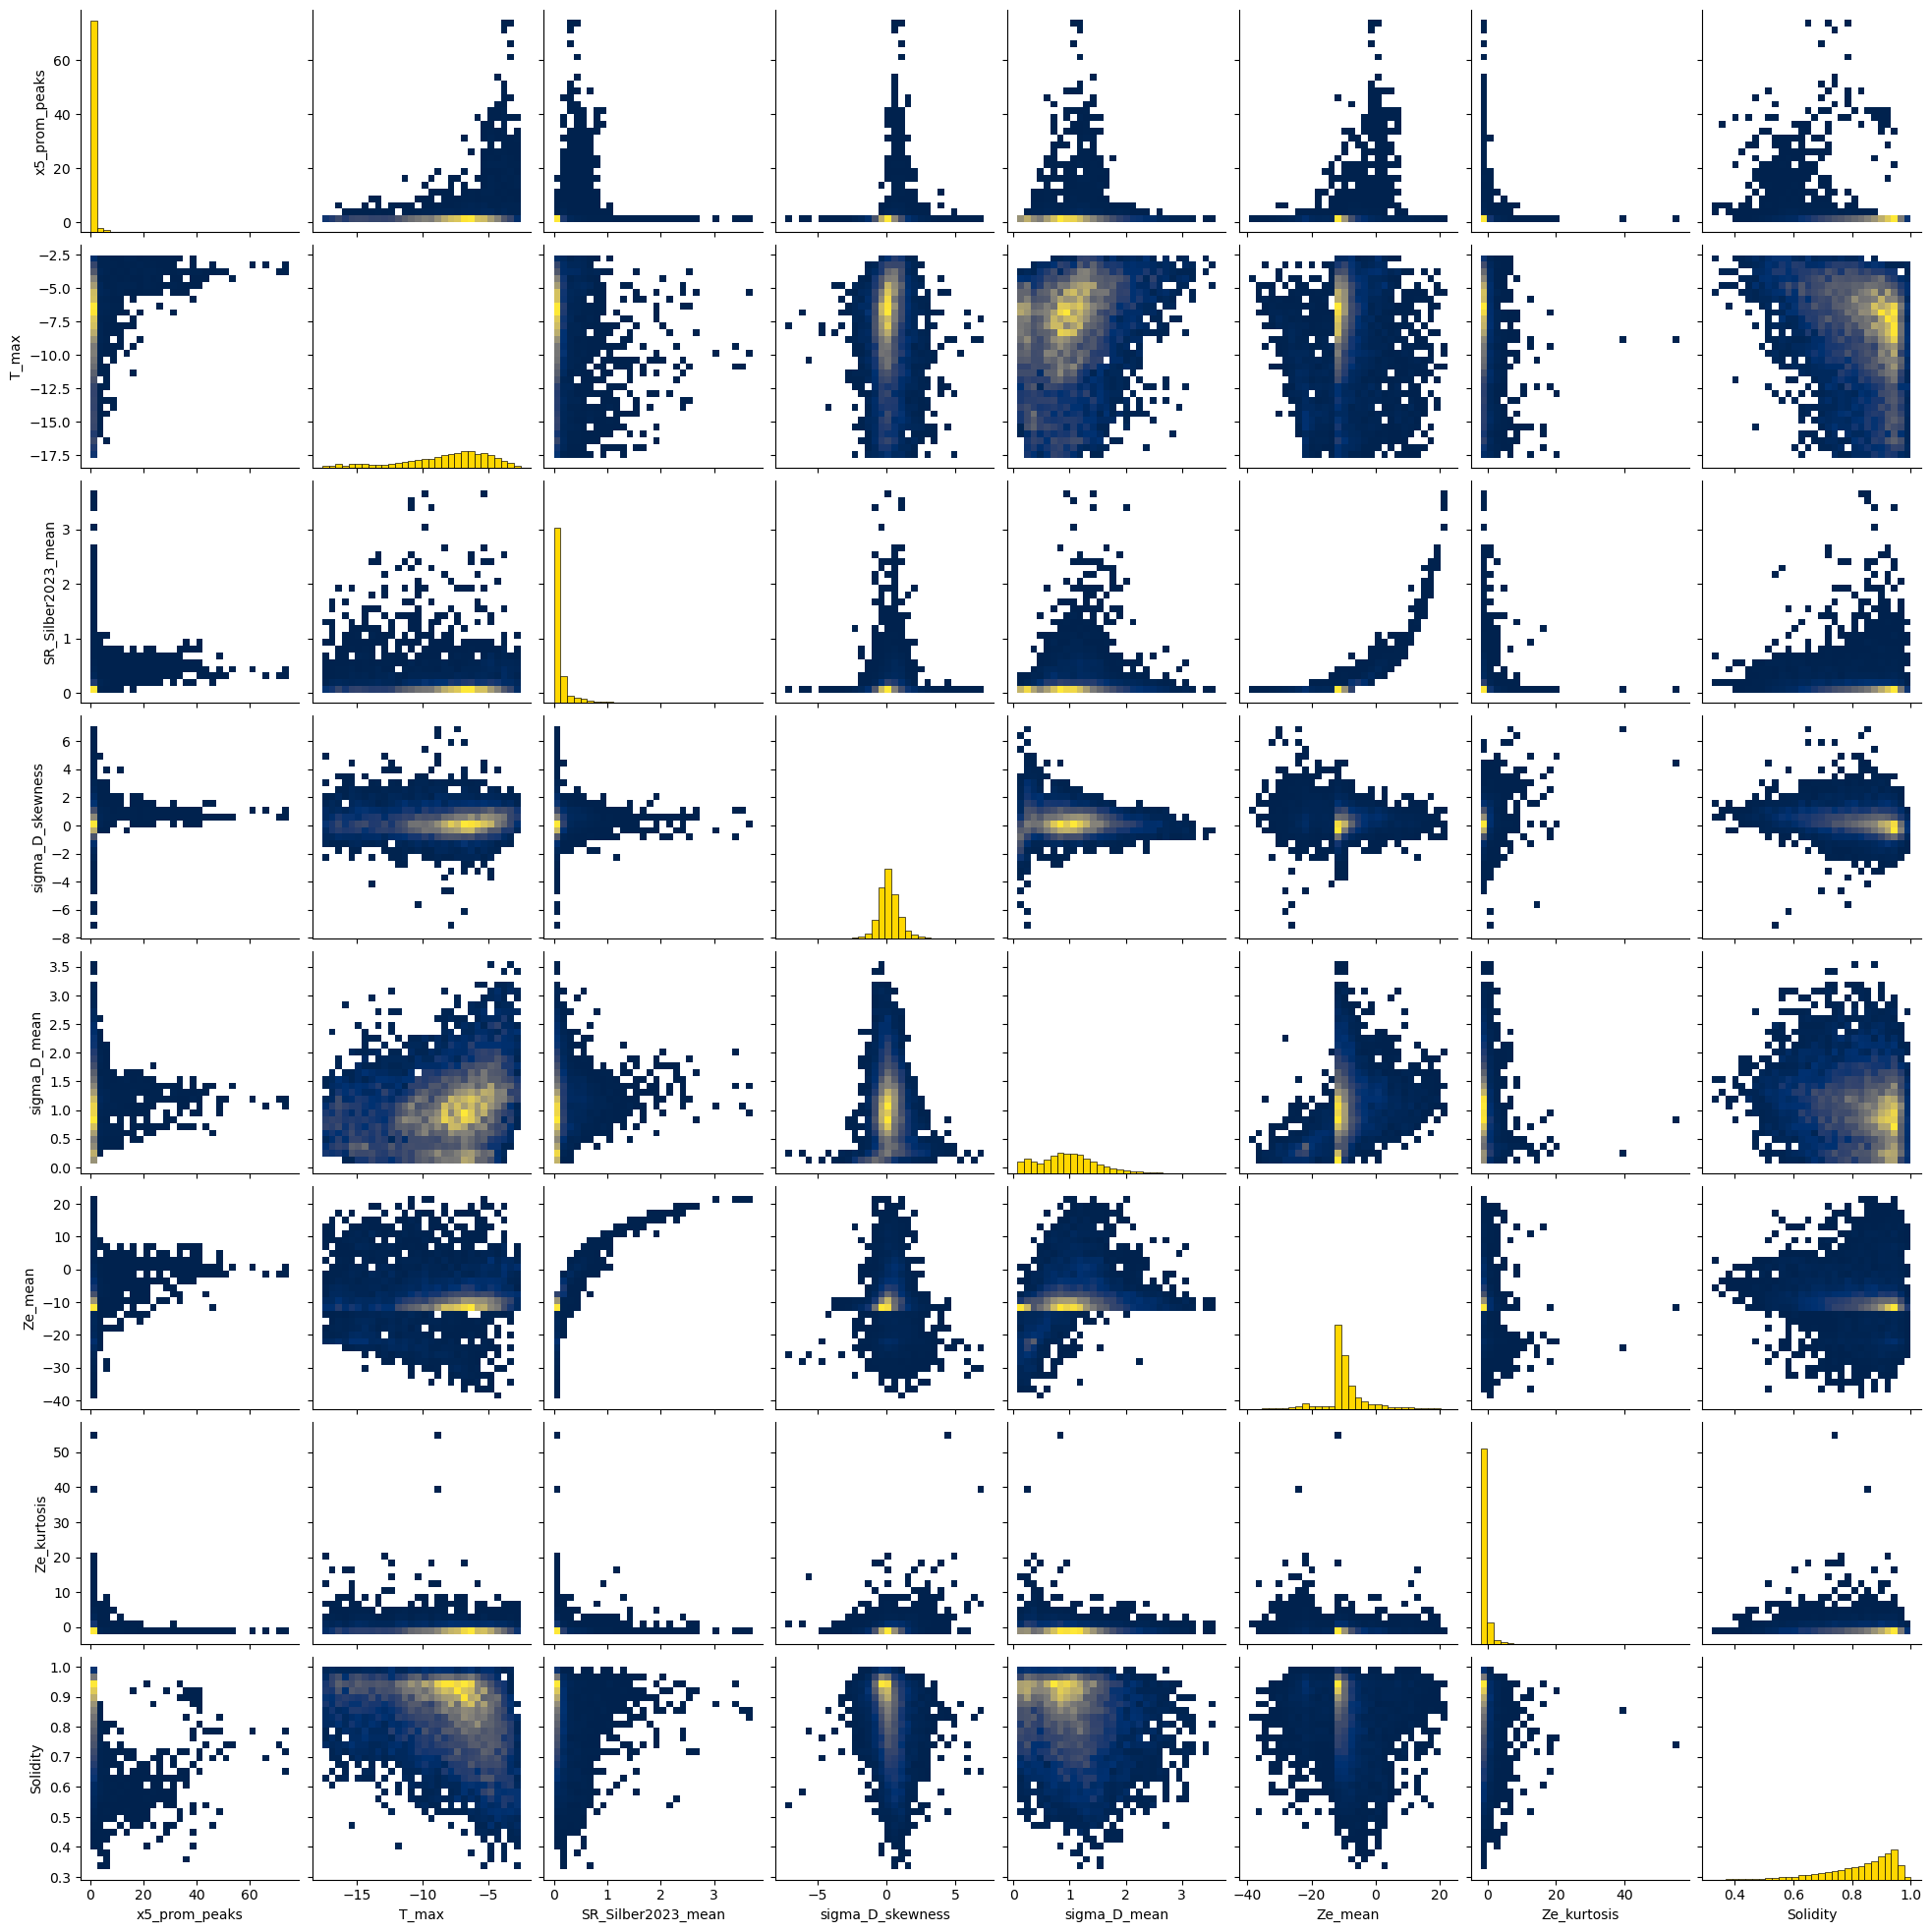

In [7]:
plots_path = './'
features_df = features_final.to_pandas()  # convert to a dataframe
vars_to_plot = ["x5_prom_peaks", "T_max", "SR_Silber2023_mean", "sigma_D_skewness",
                "sigma_D_mean", "Ze_mean", "Ze_kurtosis", "Solidity"]  # variables to plot
Jhist = sns.pairplot(features_df, vars=vars_to_plot, kind="hist", plot_kws={"cmap":"cividis", "bins":30},
                     diag_kws={"facecolor":"gold", "bins":30})
Jhist.fig.savefig(plots_path + "hist2D.png")

Say we are interested in the scene at time step #55 (in this case, 17:46 UTC) and sweep #1 (in the case of COMBLE, corresponding to an elevation of ~0.5 degrees) and wish examine its mask. Note that if relevant, we can specify the radar elevation angle instead of specifying sweep number.
Let's first plot the mask and add the effective radar FOV edge. The large numbers associated with the clusters (the color scale) are the outcome of detected clusters per sweep receiving a unique number in the examined file (starting at 1 in the first hydrometeor-containing scene of a day). In this case, in the 17:46:29 PPI scan at sweep 1, the algorithm already detected more than 1,850 hydrometeor clusters at that sweep (elevation angle) since 00 UTC.

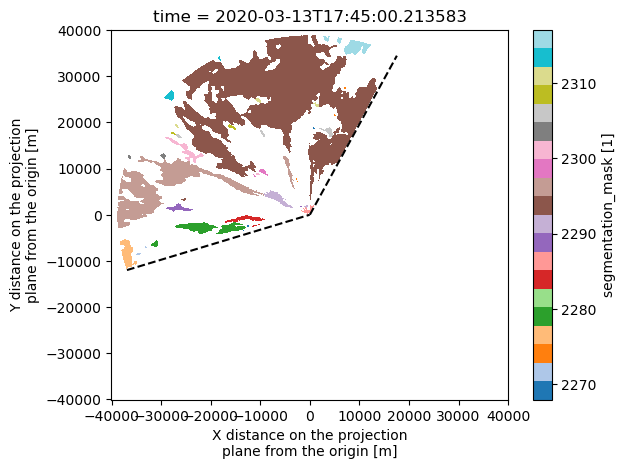

In [28]:
# Specify sweep and time index
# ====================================
sweep = 1
time_ind = 55

segments_da, features_ds = select_single_mask(segments_final, features_final, time_ind, sweep)
fig, ax = plt.subplots()
segments_da.where(lambda x: x > 0).plot(cmap='tab20', ax=ax)
edge_ind = eval(segments_final.attrs[f"edge_indices_for_sweep_{sweep}"])  # get indices of radar FOV edge (deployment specific)
add_sector_edge_lines(ax, segments_final["x"].values, sweep, edge_ind,
                          site=segments_final.attrs['site_id'], c='k', linestyle='--')

Using information from the features dataset, we can examine which clusters are fully within the radar FOV and which are not, and also look into second-trip echo candidates.

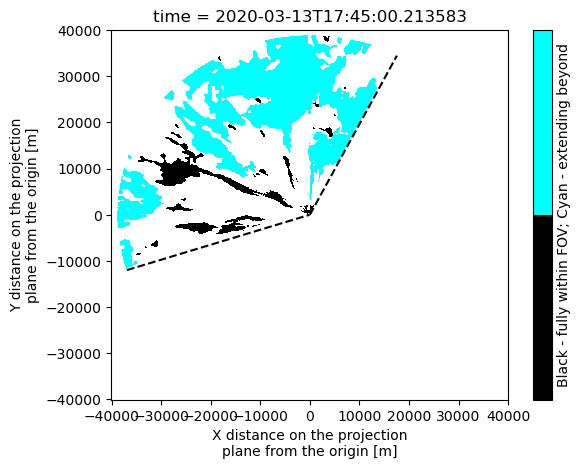

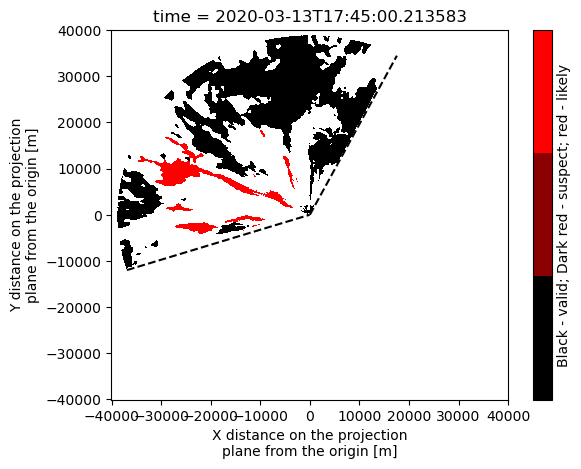

In [35]:
# Plot edge flag
edge_map = matplotlib.cm.jet.from_list('double', ('k', 'cyan'), N=2)
edge_field_da = assign_field_to_mask(segments_final, features_final, "edge_flag", time_ind, sweep)
fig, ax = plt.subplots()
edge_field_da.plot(ax=ax, cmap=edge_map, cbar_kwargs={
    "ticks": [], "label": "Black - fully within FOV; Cyan - extending beyond"})
add_sector_edge_lines(ax, segments_final["x"].values, sweep, edge_ind,
                      site=segments_final.attrs['site_id'], c='k', linestyle='--')

# Plot second trip candidates flag
edge_map = matplotlib.cm.jet.from_list('double', ('k', 'darkred', 'red'), N=3)
second_trip_da = assign_field_to_mask(segments_final, features_final, "second_trip_flag", time_ind, sweep)
fig, ax = plt.subplots()
second_trip_da.plot(ax=ax, cmap=edge_map, cbar_kwargs={
    "ticks": [], "label": "Black - valid; Dark red - suspect; red - likely"})
add_sector_edge_lines(ax, segments_final["x"].values, sweep, edge_ind,
                      site=segments_final.attrs['site_id'], c='k', linestyle='--')

We can also examine the skewness of Ze (or a different summary field in the features dataset) per hydrometeor cluster, for example.

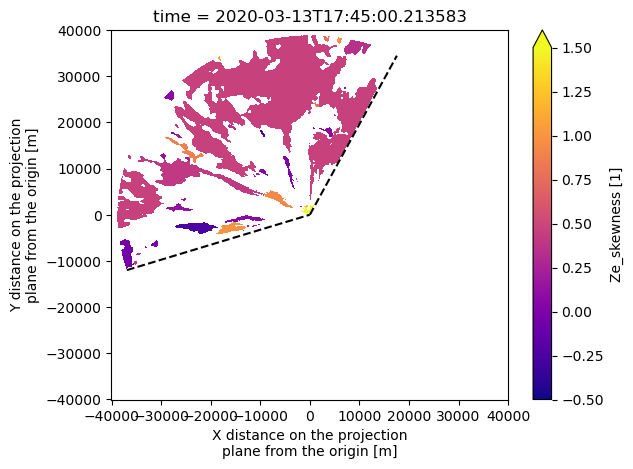

In [36]:
mask_field_da = assign_field_to_mask(segments_final, features_final, "Ze_skewness", time_ind=time_ind, sweep=sweep)
fig, ax = plt.subplots()
mask_field_da.plot(ax=ax, vmin=-0.5, vmax=1.5, cmap="plasma")
add_sector_edge_lines(ax, segments_final["x"].values, sweep, edge_ind, site='anx', c='k', linestyle='--')

Finally, examining the full scene again, we can evaluate the properties of fitted ellipses to each hydrometeor cluster. Here we use information from the `features_ds` dataset to plot the fitted ellipses, their semi-major axes, and provide the detected hydrometeor cluster area in km<sup>2</sup>.

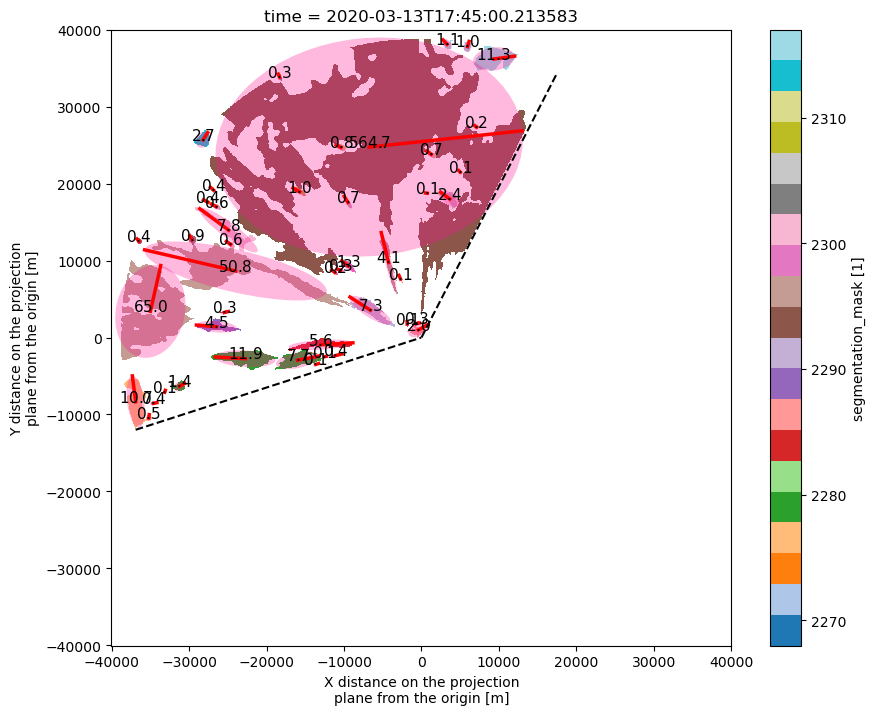

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
centroid_y = features_ds["ellipse_fit_centroid_y"].values
centroid_x = features_ds["ellipse_fit_centroid_x"].values
orientation = features_ds["ellipse_fit_orientation"].values
orientation = features_ds["ellipse_fit_orientation"].values
a = features_ds["ellipse_fit_a_axis"].values * 1e3
c = features_ds["ellipse_fit_c_axis"].values * 1e3
A = features_ds["area"].values
segments_da.where(lambda x: x > 0).plot(ax=ax, cmap='tab20')
for ii in np.unique(segments_da)[1:]:  # excluding a value of 0
    floc = features_ds["feature"].values == ii  # index of cluster in features_ds
    if np.sum(floc) == 0:  # in case of features_ds and segments_da inconsistency (occasional tobac output -see their docs)
        continue
    floc = np.argwhere(floc).item()
    a1 = centroid_x[floc] + np.sin(orientation[floc] * np.pi / 180.) * 0.5 * a[floc]
    c1 = centroid_y[floc] + np.cos(orientation[floc] * np.pi / 180.) * 0.5 * a[floc]
    ax.plot((centroid_y[floc], c1), (centroid_x[floc], a1), '-r', linewidth=2.5)
    ellipse = Ellipse((centroid_y[floc], centroid_x[floc]),
                      a[floc],
                      c[floc],
                      angle=orientation[floc], alpha=0.3, facecolor='deeppink')
    ax.add_artist(ellipse)
    text_2_add = f"${A[floc]:.1f}$"
    ax.text(centroid_y[floc], centroid_x[floc], text_2_add,
            fontsize=11, color='k', ha='center')
add_sector_edge_lines(ax, segments_final["x"].values, sweep, edge_ind, site='anx', c='k', linestyle='--')